# Pasta image dataset을 활용한 Pasta Classification

사전에 교수님께 전달한 주제는 segmentaion 및 dection이었으나 진행에 어려움을 느껴 classification으로 주제를 수정하였다.

**1. 프로젝트의 motivation**

 파스타 면의 종류를 분류하여 해당 파스타에 어떤 재료가 필요한지 판단한다.
 이는 사진을 인식하여 요리 종류를 구분함으로써 레시피, 영양 정보 등 식이 조절이 필요한 이들에게 도움이 되는 서비스를 제공하는 데에 도움을 기대할 수 있다.

**2. 프로그램의 데이터 패턴 종류**

사용한 데이터 패턴은 이미지 프레임이다. jpg 형식의 이미지를 input으로 사용하였다.

**3. 데이터 수집 과정 및 augmentation 사용 기술**

kaggle의 pasta 이미지 데이터셋과 iphone 카메라로 촬영한 이미지 데이터를 사용했다. 총 100여 개의 적은 데이터셋을 사용하기 때문에 원할한 학습을 위해 data augmentation을 진행하였다. ImageDataGenerator() 함수를 사용하여 filp, zoom, shear, rescale 등을 적용하였다.

**4. 전이학습이나, 타인의 데이터를 추가한 경우, 그 데이터에 대한 설명**

ResNet50을 전이학습 하여 학습에 적용하였다. CNN을 기반으로 한 이미지 classification에서 학습의 정확도를 높이기 위해 ResNet을 활용함을 알게 되어 텐서플로우에서 지원하는 ResNet50을 transfer learning 하였다. ResNet은 residual value를 사용하여 vanishing gradient 문제를 해결하고 parameter 개수를 줄여 학습 속도 향상에 도움이 된다.


추가한 데이터는 kaggle의 pasta dataset이다. kaggle의 image data에 대한 정보는 "데이터섯 다운로드" 과정에서 확인할 수 있다.


kaggle pasta dataset 페이지 주소
https://www.kaggle.com/datasets/aksha05/pasta-classification

**5. 데이터의 크기 및 개수, 용량, 데이터 크기의 타당성**

kaggle에서 받은 데이터셋에서는 train data 이미지가 126개, test data 이미지가 50개로 모두 3개의 클래스로 구분이 되어 있다. 이미 testset과 dataset의 이미지가 고루 섞여 있어 별도의 shuffle 과정은 추가하지 않았다.
총 용량은 21MB이다.

*   fusilli
*   penne
*   spaghetti




직접 추가한 데이터는 spaghetti에 해당하는 이미지 3개이고, train dataset에 추가하여 학습을 진행하고자 한다.

우선 데이터를 추가하지 않고 학습을 진행한 뒤 데이터 추가한 모델의 결과와 비교한다.

*   without My Data
*   with My Data



## 데이터셋 다운로드

In [ ]:
import tensorflow as tf

# GPU 사용 가능 여부 확인
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if physical_devices:
    print("GPU가 발견되었습니다.")
    # GPU 메모리 증가를 위해 필요한 코드
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("GPU를 찾을 수 없습니다. CPU를 사용합니다.")


GPU가 발견되었습니다.


우선 kaggle dataset을 다운받는다.

In [ ]:
# 이미지 데이터셋 다운로드
!git clone https://github.com/kforpp0121/2024DPR_Proj.git

train_data_dir = '2024DPR_Proj/dataset/train_data'
test_data_dir = '2024DPR_Proj/dataset/test_data'

Cloning into '2024DPR_Proj'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 212 (delta 2), reused 15 (delta 2), pack-reused 197
Receiving objects: 100% (212/212), 60.97 MiB | 40.41 MiB/s, done.
Resolving deltas: 100% (4/4), done.


[240 240 240]
<class 'numpy.ndarray'>
(440, 880, 3)


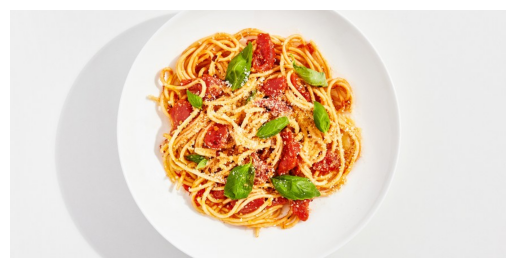

In [ ]:
# train_set의 spaghetti 이미지를 한 개 확인
import cv2
import matplotlib.pyplot as plt

# 컬러로 이미지를 로드
image_bgr = cv2.imread("/content/2024DPR_Proj/dataset/test_data/spaghetti/spaghetti44.jpg", cv2.IMREAD_COLOR)

# RGB로 변환
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

print(image_rgb[0,0])  # 이미지 픽셀
print(type(image_rgb))     # 이미지 타입
print(image_rgb.shape)     # 이미지 차원

# 이미지를 출력
plt.imshow(image_rgb), plt.axis("off")
plt.show()

**6. 딥러닝 프로그래밍 설명**

총 세 개의 모델을 학습하였다.
가장 기본적인 CNN 모델, CNN 모델에 ResNet50을 전이학습시킨 모델, 마지막으로 CNN 모델에서 validation dataset을 별도로 나눠 학습시킨 모델이다.
자세한 모델 구조 설명은 주석에 첨부하였다.

*   CNN model
*   ResNet50 model
*   CNN model with validation dataset



## 학습 및 평가 without My Data

기본적으로 eppchs = 20, batch size = 32, activation = relu와 softmax, loss function = categorical crossentropy, optimizer = adam을 사용하였다.

### CNN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 변형된 이미지를 활용하기 위해 이미지 데이터 증강
train_datagen = ImageDataGenerator(rescale=1./255,                              # 이미지의 픽셀 값을 0~1 사이로 조절
                                   shear_range=0.2,                             # 전단 변환
                                   zoom_range=0.2,                              # 확대 또는 축소
                                   rotation_range=40,                           # 회전
                                   width_shift_range=0.2,                       # 수평으로 이동
                                   height_shift_range=0.2,                      # 수직으로 이동
                                   horizontal_flip=True)                        # 수평으로 뒤집기
test_datagen = ImageDataGenerator(rescale=1./255)

# 이미지 데이터를 배치로 변환
batch_size = 32       # 배치 사이즈를 32로 설정
train_generator = train_datagen.flow_from_directory(train_data_dir,             # 이미지 데이터셋이 폴더 별로 정리되어 있으므로 flow_from_directory 함수를 사용하여 데이터를 불러온다.
                                                    target_size=(150, 150),     # 이미지 크기를 150x150 픽셀로 리사이즈. 빠른 학습을 위하여 작은 사이즈를 선택하였다.
                                                    batch_size=batch_size,      # 배치 사이즈 32
                                                    class_mode='categorical')   # 클래스가 3개인 다중 분류이므로 'categorical' 매개변수 설정.
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(150, 150),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

# CNN 모델 구축
# 활성화 함수로 ReLU를 선택하였고 convolution, pooling, FC layer로 구성된다.
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),           # 필터=32, 커널=(3,3), 입력=150x150크기의 RGB 이미지
    MaxPooling2D(2, 2),                                                         # 2x2 풀링
    Conv2D(64, (3, 3), activation='relu'),                                      # 필터=64
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),                                     # 필터=128
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),                                     # 필터=128
    MaxPooling2D(2, 2),
    Flatten(),                                                                  # flatten. 1차원 배열로 변환
    Dense(512, activation='relu'),                                              # fully connected layer.
    Dense(3, activation='softmax')                                              # 클래스 개수=3, softmax로 확률 출력
])

# 모델 컴파일
model.compile(loss='categorical_crossentropy',                                  # 다중 클래스 분류이므로 손실함수=categorical_crossentropy
              optimizer='adam',                                                 # 옵티마이저=adam
              metrics=['accuracy'])                                             # 정확도 기록

# 모델 훈련
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=20,                                                  # 에포크=20
                    validation_data=test_generator,
                    validation_steps=test_generator.samples // batch_size)

# 모델 평가
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'Test accuracy: {test_acc}')


Found 126 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Epoch 1/20
3/3 [==============================] - 5s 1s/step - loss: 1.3235 - accuracy: 0.2872 - val_loss: 1.0866 - val_accuracy: 0.4688
Epoch 2/20
3/3 [==============================] - 2s 898ms/step - loss: 1.0988 - accuracy: 0.4149 - val_loss: 1.1186 - val_accuracy: 0.3125
Epoch 3/20
3/3 [==============================] - 2s 524ms/step - loss: 1.1096 - accuracy: 0.2979 - val_loss: 1.0949 - val_accuracy: 0.3438
Epoch 4/20
3/3 [==============================] - 1s 490ms/step - loss: 1.0976 - accuracy: 0.3085 - val_loss: 1.1022 - val_accuracy: 0.2812
Epoch 5/20
3/3 [==============================] - 2s 642ms/step - loss: 1.0921 - accuracy: 0.3191 - val_loss: 1.0873 - val_accuracy: 0.4062
Epoch 6/20
3/3 [==============================] - 1s 497ms/step - loss: 1.0906 - accuracy: 0.3830 - val_loss: 1.1095 - val_accuracy: 0.4062
Epoch 7/20
3/3 [==============================] - 1s 509ms/step - loss: 1.0818 - a

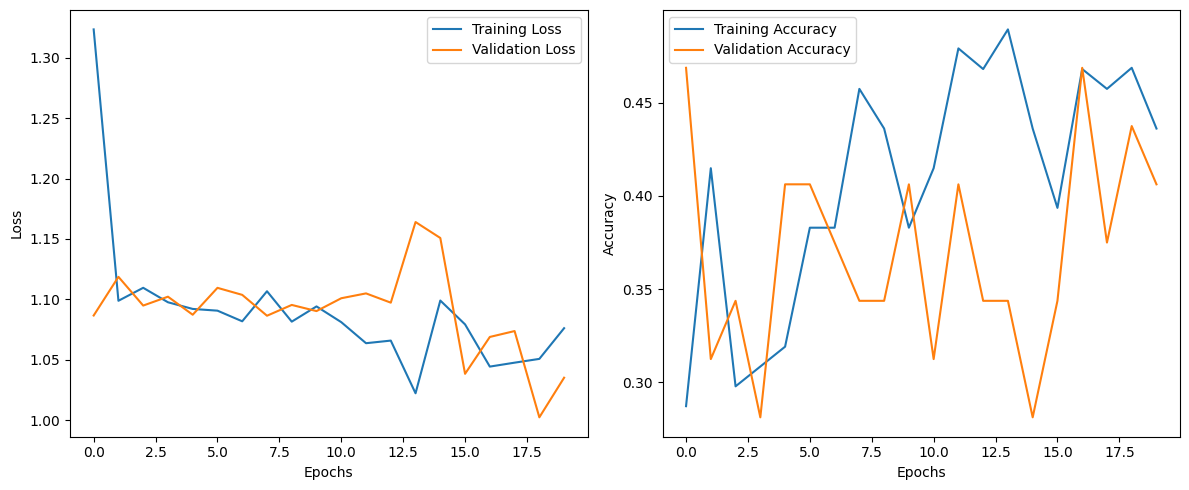

In [ ]:
# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Transfer learning with ResNet50

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# 변형된 이미지를 활용하기 위해 이미지 데이터 증강
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# 이미지 데이터를 배치로 변환
batch_size = 32
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(150, 150),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(150, 150),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

# ResNet50 모델 불러오기
# 초기 가중치=ImageNet, FC layer 포함하지 않음, 입력 크기=(150, 150, 3)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# 모델 구축
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')  # 클래스 개수에 맞게 설정
])

# ResNet50의 가중치 동결하기
base_model.trainable = False

# 모델 컴파일
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=20,
                    validation_data=test_generator,
                    validation_steps=test_generator.samples // batch_size)

# 모델 평가
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'Test accuracy: {test_acc}')

Found 126 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Epoch 1/20
3/3 [==============================] - 6s 1s/step - loss: 9.8577 - accuracy: 0.3404 - val_loss: 15.8201 - val_accuracy: 0.3125
Epoch 2/20
3/3 [==============================] - 2s 649ms/step - loss: 6.9595 - accuracy: 0.5106 - val_loss: 2.4537 - val_accuracy: 0.3750
Epoch 3/20
3/3 [==============================] - 2s 709ms/step - loss: 2.8990 - accuracy: 0.2979 - val_loss: 1.6851 - val_accuracy: 0.3125
Epoch 4/20
3/3 [==============================] - 2s 908ms/step - loss: 1.8299 - accuracy: 0.4468 - val_loss: 3.4326 - val_accuracy: 0.4375
Epoch 5/20
3/3 [==============================] - 1s 533ms/step - loss: 2.3251 - accuracy: 0.5000 - val_loss: 2.7162 - val_accuracy: 0.5625
Epoch 6/20
3/3 [==============================] - 1s 517ms/step - loss: 2.0088 - accuracy: 0.4681 - val_loss: 1.0412 - val_accuracy: 0.3438
Epoch 7/20
3/3 [==============================] - 2s 658ms/step - loss: 1.6786 - 

CNN 모델보다 ResNet을 사용한 모델의 accuracy가 더 높은 것을 확인할 수 있다.

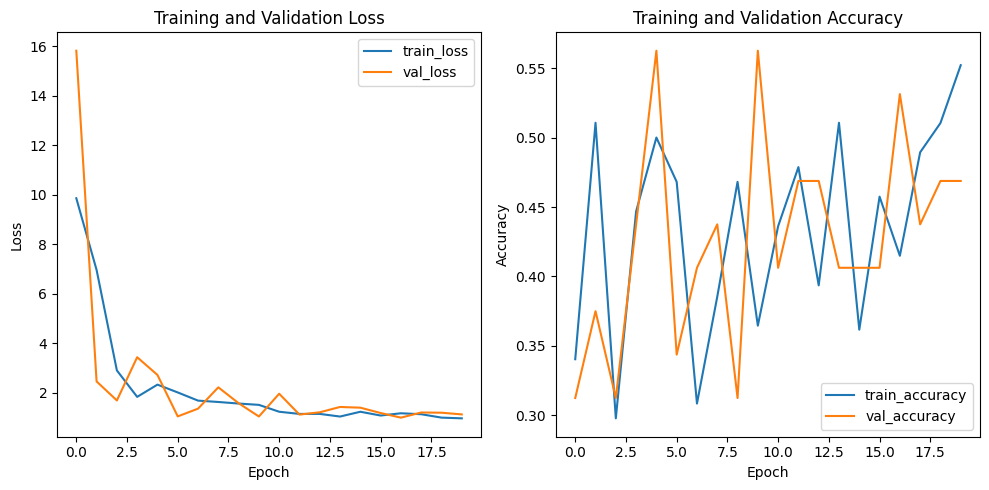

In [ ]:
# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

CNN 모델에 비해 loss가 안정적으로 감소함을 확인할 수 있다.

### CNN Model with Validation dataset

validation dataset을 train set에서 30% 분리하여 사용하도록 한다.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 변형된 이미지를 활용하기 위해 이미지 데이터 증강
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.3)                        # 0.2로 분리하면 batch_size보다 작아 0.3으로 설정

test_datagen = ImageDataGenerator(rescale=1./255)

# 이미지 데이터를 배치로 변환
batch_size = 32
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(150, 150),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(train_data_dir,
                                                         target_size=(150, 150),
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         subset='validation')

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(150, 150),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

# CNN 모델 구축
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

# 모델 컴파일
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size)

# 모델 평가
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'Test accuracy: {test_acc}')

Found 89 images belonging to 3 classes.
Found 37 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Epoch 1/20
2/2 [==============================] - 8s 2s/step - loss: 1.6980 - accuracy: 0.3158 - val_loss: 1.2649 - val_accuracy: 0.3750
Epoch 2/20
2/2 [==============================] - 2s 1s/step - loss: 1.2754 - accuracy: 0.3281 - val_loss: 1.1017 - val_accuracy: 0.3438
Epoch 3/20
2/2 [==============================] - 1s 978ms/step - loss: 1.0964 - accuracy: 0.4219 - val_loss: 1.0965 - val_accuracy: 0.3438
Epoch 4/20
2/2 [==============================] - 1s 965ms/step - loss: 1.1025 - accuracy: 0.4386 - val_loss: 1.0647 - val_accuracy: 0.5625
Epoch 5/20
2/2 [==============================] - 3s 2s/step - loss: 1.0938 - accuracy: 0.4219 - val_loss: 1.0875 - val_accuracy: 0.3750
Epoch 6/20
2/2 [==============================] - 3s 2s/step - loss: 1.1075 - accuracy: 0.2281 - val_loss: 1.0882 - val_accuracy: 0.4062
Epoch 7/20
2/2 [==============================] - 4s

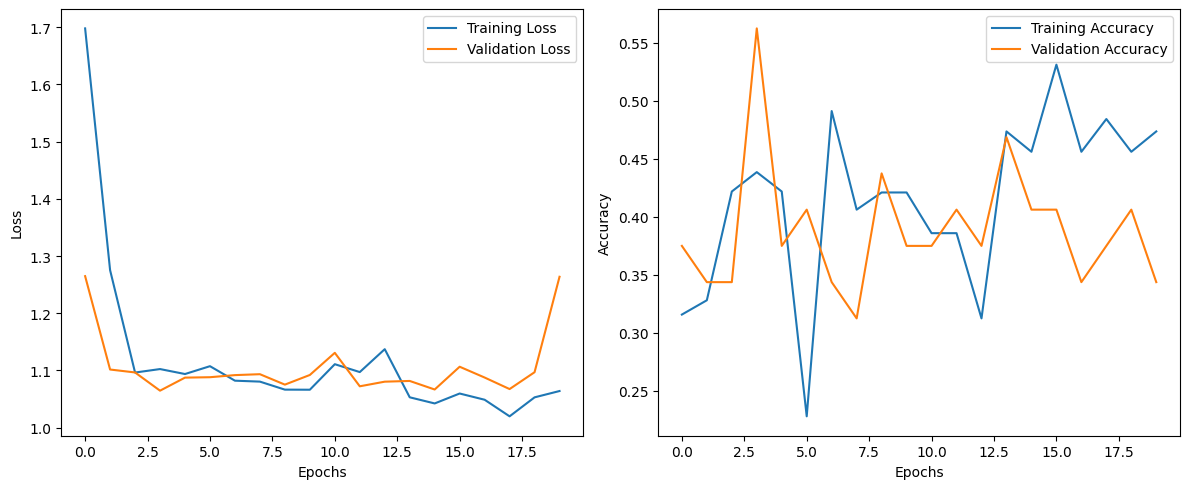

In [ ]:
# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

validation set으로 나뉘어져 train set이 작아졌기 때문인지 학습 효과가 감소하였다. 검증셋을 별도로 사용하여 학습 정확도가 비교적 완만해졌다.

## 나의 데이터 추가

이제 기존의 kaggle dataset에 내가 촬영한 이미지 데이터를 추가한다.

In [ ]:
# 데이터 추가
!wget https://raw.githubusercontent.com/kforpp0121/2024DPR_Proj/master/mydata/spaghetti_1.jpg  -O /content/2024DPR_Proj/dataset/train_data/spaghetti/spaghetti_1.jpg
!wget https://raw.githubusercontent.com/kforpp0121/2024DPR_Proj/master/mydata/spaghetti_2.jpg  -O /content/2024DPR_Proj/dataset/train_data/spaghetti/spaghetti_2.jpg
!wget https://raw.githubusercontent.com/kforpp0121/2024DPR_Proj/master/mydata/spaghetti_3.jpg  -O /content/2024DPR_Proj/dataset/train_data/spaghetti/spaghetti_3.jpg

train_data_dir = '2024DPR_Proj/dataset/train_data'
test_data_dir = '2024DPR_Proj/dataset/test_data'

--2024-06-01 07:07:49--  https://raw.githubusercontent.com/kforpp0121/2024DPR_Proj/master/mydata/spaghetti_1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 370647 (362K) [image/jpeg]
Saving to: ‘/content/2024DPR_Proj/dataset/train_data/spaghetti/spaghetti_1.jpg’

/content/2024DPR_Pr 100%[===================>] 361.96K  --.-KB/s    in 0.03s   

2024-06-01 07:07:49 (10.1 MB/s) - ‘/content/2024DPR_Proj/dataset/train_data/spaghetti/spaghetti_1.jpg’ saved [370647/370647]

--2024-06-01 07:07:49--  https://raw.githubusercontent.com/kforpp0121/2024DPR_Proj/master/mydata/spaghetti_2.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserco

[117 110 102]
<class 'numpy.ndarray'>
(1440, 1062, 3)


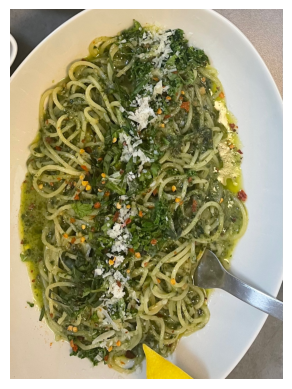

In [ ]:
# train set에 추가한 spaghetti 이미지를 한 개 확인
image = cv2.imread("/content/2024DPR_Proj/dataset/train_data/spaghetti/spaghetti_2.jpg", cv2.IMREAD_COLOR)
# RGB로 변환
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(image[0,0])  # 이미지 픽셀
print(type(image))     # 이미지 타입
print(image.shape)     # 이미지 차원

# 이미지를 출력
plt.imshow(image), plt.axis("off")
plt.show()

## 학습 및 평가 with My Data

데이터를 추가하지 않은 경우와 비교하기 위해 모든 파라미터 및 기준을 변경하지 않고 학습을 진행한다.

### CNN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 변형된 이미지를 활용하기 위해 이미지 데이터 증강
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# 이미지 데이터를 배치로 변환
batch_size = 32
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(150, 150),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(150, 150),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

# 모델 구축
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

# 모델 컴파일
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=20,
                    validation_data=test_generator,
                    validation_steps=test_generator.samples // batch_size)

# 모델 평가
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'Test accuracy: {test_acc}')


Found 129 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Epoch 1/20
4/4 [==============================] - 3s 329ms/step - loss: 1.2383 - accuracy: 0.2812 - val_loss: 1.1337 - val_accuracy: 0.1562
Epoch 2/20
4/4 [==============================] - 2s 453ms/step - loss: 1.1571 - accuracy: 0.3196 - val_loss: 1.1586 - val_accuracy: 0.2188
Epoch 3/20
4/4 [==============================] - 2s 647ms/step - loss: 1.0912 - accuracy: 0.4021 - val_loss: 1.0979 - val_accuracy: 0.3750
Epoch 4/20
4/4 [==============================] - 1s 349ms/step - loss: 1.0977 - accuracy: 0.3196 - val_loss: 1.0988 - val_accuracy: 0.3438
Epoch 5/20
4/4 [==============================] - 1s 340ms/step - loss: 1.0990 - accuracy: 0.3402 - val_loss: 1.0906 - val_accuracy: 0.4062
Epoch 6/20
4/4 [==============================] - 1s 343ms/step - loss: 1.1023 - accuracy: 0.3608 - val_loss: 1.0964 - val_accuracy: 0.3750
Epoch 7/20
4/4 [==============================] - 1s 335ms/step - loss: 1.0979 

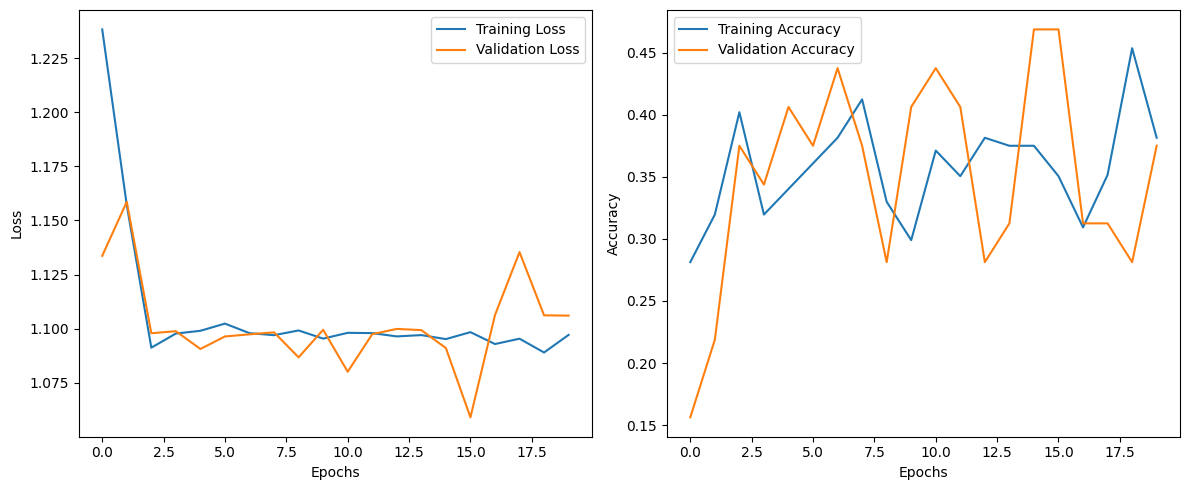

In [ ]:
# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

그래프가 튀는 현상이 발생했다. 이는 이상치가 존재하여 발생하는 것이다. rescaling 값을 올바르게 입력하지 않아 이상치가 존재하는 것으로 예상한다.

### Transfer learning with ResNet50

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# 변형된 이미지를 활용하기 위해 이미지 데이터 증강
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# 이미지 데이터를 배치로 변환
batch_size = 32
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(150, 150),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(150, 150),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

# ResNet50 모델 불러오기
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# 모델 구축
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

# ResNet50의 가중치 동결하기
base_model.trainable = False

# 모델 컴파일
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=20,
                    validation_data=test_generator,
                    validation_steps=test_generator.samples // batch_size)

# 모델 평가
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'Test accuracy: {test_acc}')

Found 129 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Epoch 1/20
4/4 [==============================] - 8s 876ms/step - loss: 7.8759 - accuracy: 0.3906 - val_loss: 4.6862 - val_accuracy: 0.2188
Epoch 2/20
4/4 [==============================] - 2s 609ms/step - loss: 4.0147 - accuracy: 0.2990 - val_loss: 2.4146 - val_accuracy: 0.3750
Epoch 3/20
4/4 [==============================] - 3s 723ms/step - loss: 2.5080 - accuracy: 0.3672 - val_loss: 1.9686 - val_accuracy: 0.3750
Epoch 4/20
4/4 [==============================] - 3s 731ms/step - loss: 2.0146 - accuracy: 0.3093 - val_loss: 2.5359 - val_accuracy: 0.2812
Epoch 5/20
4/4 [==============================] - 2s 596ms/step - loss: 1.6653 - accuracy: 0.3828 - val_loss: 1.2825 - val_accuracy: 0.2812
Epoch 6/20
4/4 [==============================] - 2s 374ms/step - loss: 1.2375 - accuracy: 0.3918 - val_loss: 1.0275 - val_accuracy: 0.4375
Epoch 7/20
4/4 [==============================] - 2s 497ms/step - loss: 1.1955 

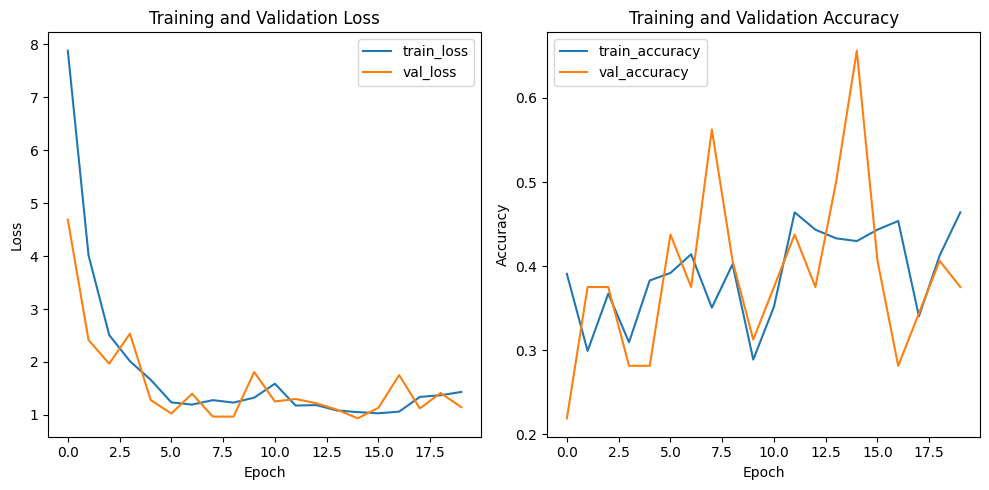

In [ ]:
# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

loss가 좀 더 안정적이나 여전히 이상치는 존재한다.

## 결론

7. 결과에 대한 충분한 분석과 설명



*   CNN만을 사용한 모델보다 ResNet50을 transfer learning한 모델에서의 loss가 더 안정적으로 감소함을 확인할 수 있다.
> 이유 : ResNet은 layer를 더 깊이 쌓을 수 있게 하여 학습 효과를 높이고 parameter 개수를 줄여 과적합을 방지한다. 때문에 ResNet과 같은 모델을 전이학습하여 학습률 상승을 기대할 수 있다.
*   My Data를 추가한 이후의 그래프를 보면 추가하기 전의 그래프와 달리 loss가 급격하게 증하하는 첨점이 있음을 확인할 수 있다.
이는 추가한 My Data가 이상치로 판단되었음을 알 수 있다.
> 원인 : 이미지 데이터를 시각화하였을 때 기존의 이미지 데이터의 픽셀 크기는 (240, 240, 240)인데에 반해 추가한 이미지 데이터의 크기는 (117, 110, 102)으로 kaggle 데이터와 달리 정제되지 않았음을 확인할 수 있다. 때문에 데이터 rescaling 등의 전처리 시 이미지 크기가 일정하게 입력되지 않았을 가능성이 있다.



8. 프로젝트를 위해 활용한 자료나 동영상 링크


데이터패턴인식 수업 자료 참고

---
이미지 시각화:
https://colab.research.google.com/github/rickiepark/machine-learning-with-python-cookbook/blob/master/08.ipynb#scrollTo=4m_HOqwRMk2Q

---
데이터:
https://velog.io/@korkite/Ch11.-ImageDataGenerator-flow-fromdirectory



https://velog.io/@junseyeon/%EB%94%A5%EB%9F%AC%EB%8B%9D-ImageDataGenerator-%EC%82%AC%EC%9A%A9%ED%95%98%EA%B8%B0

---
모델 구조:

https://brunch.co.kr/@mocha-ai/33

---
steps_for_epoch 오류 해결: 데이터셋의 크기가 배치 크기보다 작으면 steps_for_epoch에 0이 할당되는 오류가 발생한다.
https://foxtrotin.tistory.com/535

---



9. 본 프로젝트를 통해 느낀점

안정적인 학습을 위해서는 모델의 구조도 중요하지만 입력 데이터의 크기, 개수, 모양 등 특성을 일관적으로 정제할 필요가 있음을 알게 되었다. 데이터 전처리 과정에 대해 숙지할 필요를 느꼈다. 또한 전이 학습을 적용하게 되면 기존의 간단한 모델보다 학습 효과를 상승시키는 데에 효과적임을 알게 되었다. 여러 오픈 소스 모델을 적용시켜보며 해당 모델의 특징에 대해 공부하고 앞으로의 과제에 어떤 모델이 적합한지 판단할 수 있는 능력을 함양시키고자 한다.

10. 프로젝트 수행 과정에 대한 간략한 일정 고찰

적절한 이미지 데이터셋을 찾는 데에 가장 비중을 두었다. 짧은 시간 내에 모델 생성 및 학습을 완료해야 했으므로 기존의 정리된 이미지 데이터셋을 이용하여 우선적으로 학습한 후 직접 생성한 이미지를 추가하는 방향으로 진행하였다. 데이터셋 준비, 모델 생성, 학습 과정의 비율이 3:1:1 정도로 이루어졌다.